# Exploration of San Francisco and 3.5 Ghz

Given that the adoption of 5G is expected to roll out towards 2020 we need to examine how the current network infrastructure will be utilized and what areas in a city will require new deployments or upgrade.

For 5G there are [three key components](https://arxiv.org/abs/1804.05057):

1. eMBB - enhanced mobile broadband: connectivity bandwidth in the gigs per second
2. URLLC - ultra-reliable low-latency communications: near realtime with a service level gaurantee
3. mMTC - massive machine-type communications: connect different types of devices to their required connectivity

In this exploration we focus on eMBB, looking at the exisitng tower locations for traditional LTE and overlay what a 3.5 Ghz network would serve. Note this does not include the agumenation of this network with small cells of MIMO.

This would be a further exercise to handle dedicated customers and/or high bandwidth areas.

Also for URLLC, the latency to the app or service should be considered. This would require further modelling of the accesibility of the data on the edge.

Lastly, the communication and syncing of the towers, the use of the baseband should also be explored. This will drive the network topology due to the requirement of 20 ms ([3GPP release 15](http://www.3gpp.org/release-15)). Further reading from [Nokia](http://ctw2018.ieee-ctw.org/files/2018/05/5G-NR-CTW-final.pdf), [Qualcomm](https://www.qualcomm.com/media/documents/files/the-3gpp-release-15-5g-nr-design.pdf), [Ericson](https://www.ericsson.com/assets/local/narratives/networks/documents/eab-18001198-uen-rev-a.pdf).

## Assumptions

1. We are assuming that 80% of traffic occurs indoors, and that we can represent this with the business locations from the city of [San Francisco](https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD, https://data.sfgov.org/Economy-and-Community/Registered-Business-Locations-San-Francisco/g8m3-pdis). Aswell as the address locations sourced from [Open Address](http://results.openaddresses.io/sources/us/ca/san_francisco).
2. That the tower location data from the city of [San Francisco](https://data.sfgov.org/api/views/aa26-h926/rows.csv?accessType=DOWNLOAD, https://data.sfgov.org/City-Infrastructure/Existing-Commercial-Wireless-Telecommunication-Ser/aa26-h926) is accurate.
3. Assume that the net population is the same even though people will come and go based on where they work. (This would be a separate question, what is the population of SF over time, hourly, daily, weekly etc.)
4. Assume best case scenario for coverage, no elevation or barriers. The reason for this is that we want to examine the clear gaps. Once this is understood we can move to elevation and building/environmental factors.
5. From the testing of this [study](https://www.ericsson.com/assets/local/publications/conference-papers/5g_nr_sub6_coverage.pdf), 700m and 700 Mb p/s is possible and then at 1km, 100 Mb p/s is possible. Further readying on path loss [here](https://sites.google.com/site/lteencyclopedia/lte-radio-link-budgeting-and-rf-planning).


## Why San Francisco
Being one of the tech capitals of the world it attracts alot of attention and has has plans to [deploy upto 50,000 antennas](https://sanfrancisco.cbslocal.com/2017/06/28/plan-install-50000-cell-towers-california-opposition/). Further, bridging the digital divide is key to the future success of the city. There has also been some [previous analysis](https://techcrunch.com/2010/09/21/wireless-dead-zones-sf/) that would disagree with the 100% coverage claimed by AT&T.

There are also a number of ISPs (Monkey Brains, Sonic) who are deploying networks whilst the city decides what its [stragey](https://www.sfmunifiber.com/fiber_roadmap) ([and here](http://tech.sfgov.org/sites/default/files/Document/DT_Broadband%20RFQ-1-31-18%20FINAL%20to%20post%20new.pdf)) is.

### Wireless LTE coverage of SF
Blue dotted line = SF city limits

Aqua solid fill = AT&T coverage ([source](https://www.fcc.gov/mobile-deployment-form-477-data
))

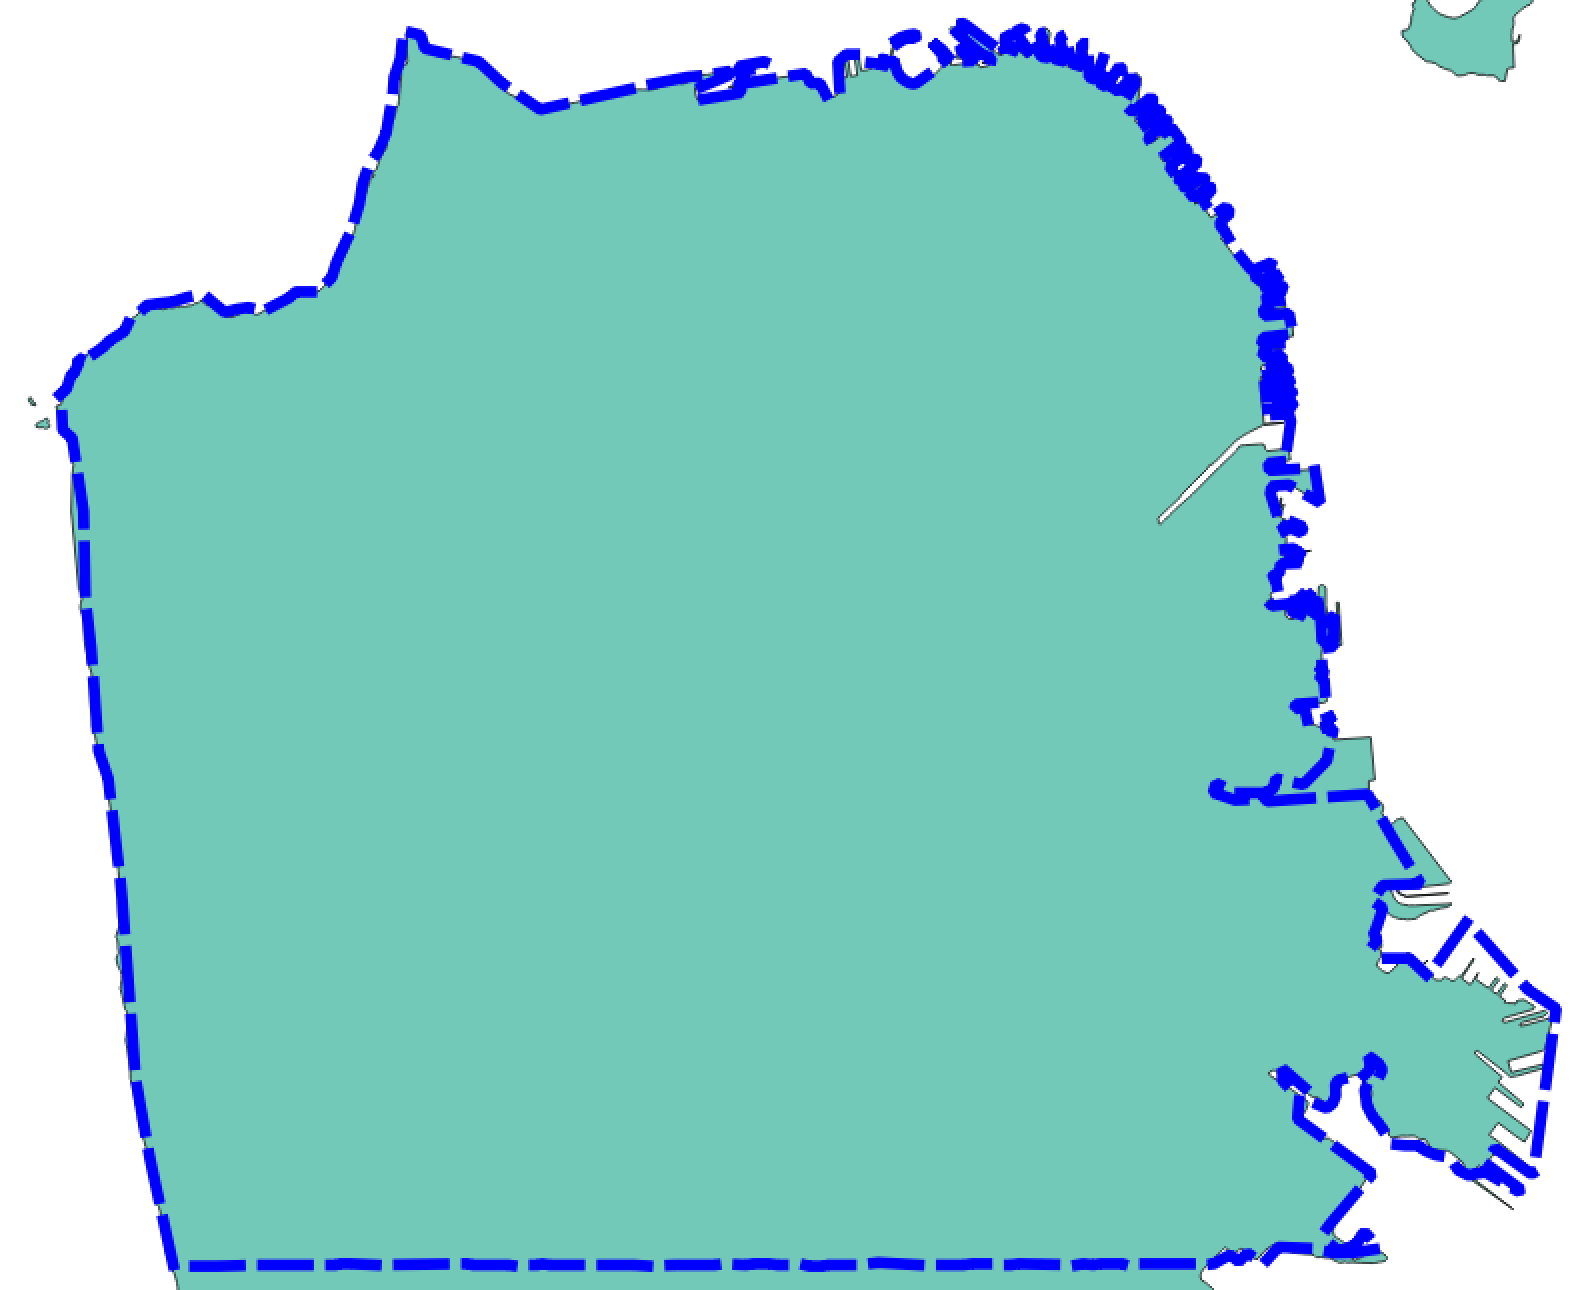

In [1]:
from IPython.core.display import Image, display
display(Image('./coverage_of_SF_ATT.png', width=400, unconfined=True))

## Analysis

How can we visualize the areas that will fall short on the potential 5G coverage?

1. Clip the city boundary data to just the main area
2. Create a grid based off of the extent of the boundary - use [MMQGIS](http://michaelminn.com/linux/mmqgis/)
3. Import the cell tower locations
4. Match the cell tower locations with their cell. Using compbio/rasmus (pip install https://codeload.github.com/mdrasmus/compbio/tar.gz/v0.9), [further reading](http://blog.notdot.net/2009/11/Damn-Cool-Algorithms-Spatial-indexing-with-Quadtrees-and-Hilbert-Curves)
5. Create a graph that connects every cell to its neighboring cells
6. Find the shortest path for every cell to its nearest tower. (It will be fast just to compute all_paths and then find the shortest path by indexing.)
7. Visualize the areas that have < 700 Mb

Note: 1 and 2 have been completed in QGIS.

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
!command curl https://data.sfgov.org/api/views/aa26-h926/rows.csv?accessType=DOWNLOAD > ./data/sf_towers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  251k    0  251k    0     0   293k      0 --:--:-- --:--:-- --:--:--  293k


In [4]:
t_df = pd.read_csv('./data/sf_towers.csv', sep=',')
t_df.shape

(1253, 21)

In [5]:
t_df.head()

,Carrier,ID,Search Ring Name ID,Block,Lot,Zoning District,Hight and Bulk District,Type of Building,Preference (1-7),Type of Consumer Services,...,Number of Antennas,Location of BTS,Type of Technology,Radio Frequency Range (Megahertz),Power Output of Equipment (Watts),Height to Top of Antenna,Name of Community Liason,Phone Number of Community Liason,Comments,Location 1
0,AT&T,CCL00001,Marshall Hale,1017,28,RM-2,80-E,Commercial,7,"voice, video & data",...,9,Basement,"UMTS, LTE","700, 850, 1900,1700,2300",16650,87,Jim Sidorick,925-277-6026,NaN,"Sacramento\n(37.786884, -122.45489)"
1,AT&T,CCL00002,Embarcadero,237,014/016,C-3-O,350-S,Commercial,NaN,"voice, video & data",...,9,Basement,"UMTS, LTE","700, 850, 1900,1700,2300",16650,252,Jim Sidorick,925-277-6026,NaN,"Sacramento\n(37.793983, -122.39962)"
2,AT&T,CCL00005,Mercy High School,7231,3,RH-1(D),40-X,Public,1,"voice, video & data",...,12,Ground Fl,"UMTS, LTE","700, 850, 1900,1700,2300",16650,67,Jim Sidorick,925-277-6026,NaN,"19th\n(37.729811, -122.47384)"
3,AT&T,CCL00006,Bernal Heights,3637,69,MISSION STREET,40-X/65-B,Commercial,6,"voice, video & data",...,9,Ground Fl,"UMTS, LTE","700, 850, 1900,1700,2300",16650,120,Jim Sidorick,925-277-6026,NaN,"Mission\n(37.755217, -122.41836)"
4,AT&T,CCL00049,Marina Safeway,503,30,RC-3,65-A/40-X,Commercial,4,"voice, video & data",...,6,Basement,"UMTS, LTE","700, 850, 1900,1700,2300",7182,127,Jim Sidorick,925-277-6026,NaN,"Van Ness\n(37.800865, -122.42503)"


Now we want to filter out the non AT&T locations

In [6]:
t_df = t_df[t_df.Carrier == 'AT&T']
t_df.shape

(259, 21)

OK, so it looks like we need to parse out the coordinates from the "Location 1" field. It looks to be seperated by a new line character. Lets try add a column with the cleaned value.

In [7]:
t_df = pd.concat([t_df, t_df['Location 1'].str.split('\n', expand=True)], axis=1)
t_df = t_df.drop_duplicates(subset=1, keep='last')
t_df.head()

,Carrier,ID,Search Ring Name ID,Block,Lot,Zoning District,Hight and Bulk District,Type of Building,Preference (1-7),Type of Consumer Services,...,Type of Technology,Radio Frequency Range (Megahertz),Power Output of Equipment (Watts),Height to Top of Antenna,Name of Community Liason,Phone Number of Community Liason,Comments,Location 1,0,1
0,AT&T,CCL00001,Marshall Hale,1017,28,RM-2,80-E,Commercial,7,"voice, video & data",...,"UMTS, LTE","700, 850, 1900,1700,2300",16650,87,Jim Sidorick,925-277-6026,NaN,"Sacramento\n(37.786884, -122.45489)",Sacramento,"(37.786884, -122.45489)"
1,AT&T,CCL00002,Embarcadero,237,014/016,C-3-O,350-S,Commercial,NaN,"voice, video & data",...,"UMTS, LTE","700, 850, 1900,1700,2300",16650,252,Jim Sidorick,925-277-6026,NaN,"Sacramento\n(37.793983, -122.39962)",Sacramento,"(37.793983, -122.39962)"
2,AT&T,CCL00005,Mercy High School,7231,3,RH-1(D),40-X,Public,1,"voice, video & data",...,"UMTS, LTE","700, 850, 1900,1700,2300",16650,67,Jim Sidorick,925-277-6026,NaN,"19th\n(37.729811, -122.47384)",19th,"(37.729811, -122.47384)"
3,AT&T,CCL00006,Bernal Heights,3637,69,MISSION STREET,40-X/65-B,Commercial,6,"voice, video & data",...,"UMTS, LTE","700, 850, 1900,1700,2300",16650,120,Jim Sidorick,925-277-6026,NaN,"Mission\n(37.755217, -122.41836)",Mission,"(37.755217, -122.41836)"
4,AT&T,CCL00049,Marina Safeway,503,30,RC-3,65-A/40-X,Commercial,4,"voice, video & data",...,"UMTS, LTE","700, 850, 1900,1700,2300",7182,127,Jim Sidorick,925-277-6026,NaN,"Van Ness\n(37.800865, -122.42503)",Van Ness,"(37.800865, -122.42503)"


In [8]:
t_df.shape

(259, 23)

Note that the data is still a string and we want a tuple with floating points. We can parse this out when we run the intersection.

Now lets load the grid data.

In [9]:
g_df = gpd.read_file("./data/sf_grid.shp")

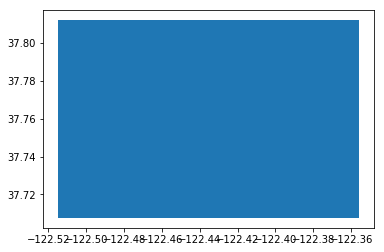

In [10]:
%matplotlib inline
g_df.plot()

In [11]:
g_df.shape

(26019, 5)

It also turns out that the grid functionality creates the rows one at a time. By looking in QGIS we can see that each row as 177 cells. That means we have 26019 / 177 = 147 rows.

In [12]:
from rasmus.quadtree import QuadTree

In [13]:
q_tree = QuadTree(37.760000000, 122.43000000, 27000, depth=5)

In [14]:
for i, f in enumerate(g_df.geometry):
    coords = list(f.exterior.coords)
    q_tree.insert(i, [coords[0][1], coords[0][0], coords[2][1], coords[2][0]])

In [15]:
hits = []
for a in t_df[1]:
    # split up the string into "(lat" and " lon)"
    s_lat, s_lon = a.split(',')
    # clean the strings so that we get 1.23 and 4.56
    lat = float(s_lat[1:])
    lon = float(s_lon[1:-1])

    hits.append(q_tree.query([lat, lon, lat, lon]).pop())

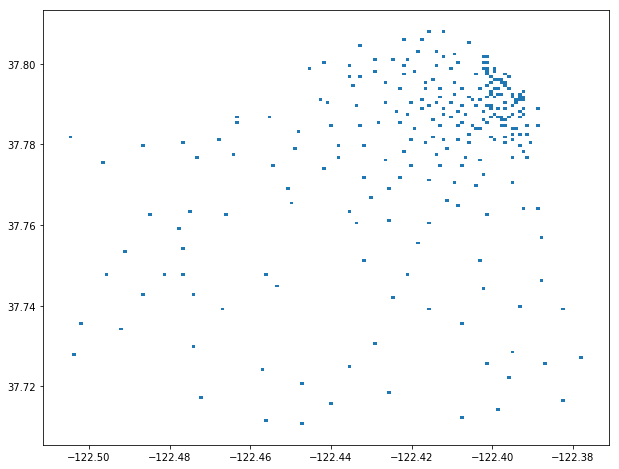

In [16]:
t_df = g_df.loc[hits]
t_df.plot(figsize=(20,8))

Now lets make that network so we can trace from each cell to its nearest tower. We could also do this with [nearest neighbor](https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html).

In [17]:
import networkx as nx

c_graph = nx.Graph()

for i in range(2, 177):
    for j in range(2, 147):
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i, j + 1), weight=79.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i, j - 1), weight=79.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i + 1, j), weight=79.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i - 1, j), weight=79.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i + 1, j + 1), weight=111.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i + 1, j - 1), weight=111.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i - 1, j + 1), weight=111.)
        c_graph.add_edge("%i_%i"% (i, j), "%i_%i"% (i - 1, j - 1), weight=111.)
len(c_graph.nodes())

26019

In [18]:
from math import ceil, floor
for h in hits:
    index = (int(i) * 147) + 1 - int(j)
    i = ceil(h / 147)
    j = (147 * i) + 1 - h
    for a in nx.single_source_dijkstra_path_length(c_graph, source='%i_%i'% (i, j), cutoff=1000):
        if not c_graph.node[a].get('speed', False):
            c_graph.node[a]['speed'] = 100

    for b in nx.single_source_dijkstra_path_length(c_graph, source='%i_%i'% (i, j), cutoff=700):
        c_graph.node[b]['speed'] = 1000



In [19]:
print(len([n for n, d in c_graph.nodes(data=True) if d.get('speed', False)]))

18233


So it turns out that the grid file actually goes like this:
```
146 .
. .
1 . .
0 147 .
```

Therefore we need to transform our values to the actual values of the indexs

In [20]:
speeds = [0 for i in range(0, 26019)]

for n, d in c_graph.nodes(data=True):
    i, j = n.split('_')
    index = (int(i) * 147) + 1 - int(j)
    speed = d.get('speed', 0)

    speeds[index - 1] = speed

In [21]:
s_df = pd.DataFrame.from_dict({'speed': speeds})
s_df.describe()

,speed
count,26019.000000
mean,572.600792
std,481.583226
min,0.000000
25%,0.000000
50%,1000.000000
75%,1000.000000
max,1000.000000


In [22]:
sg_df = g_df.join(s_df)

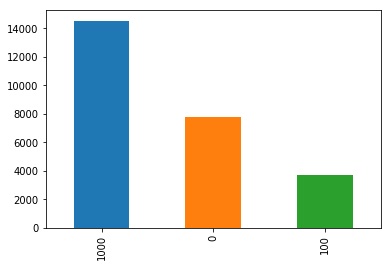

In [23]:
pd.value_counts(sg_df['speed']).plot.bar()

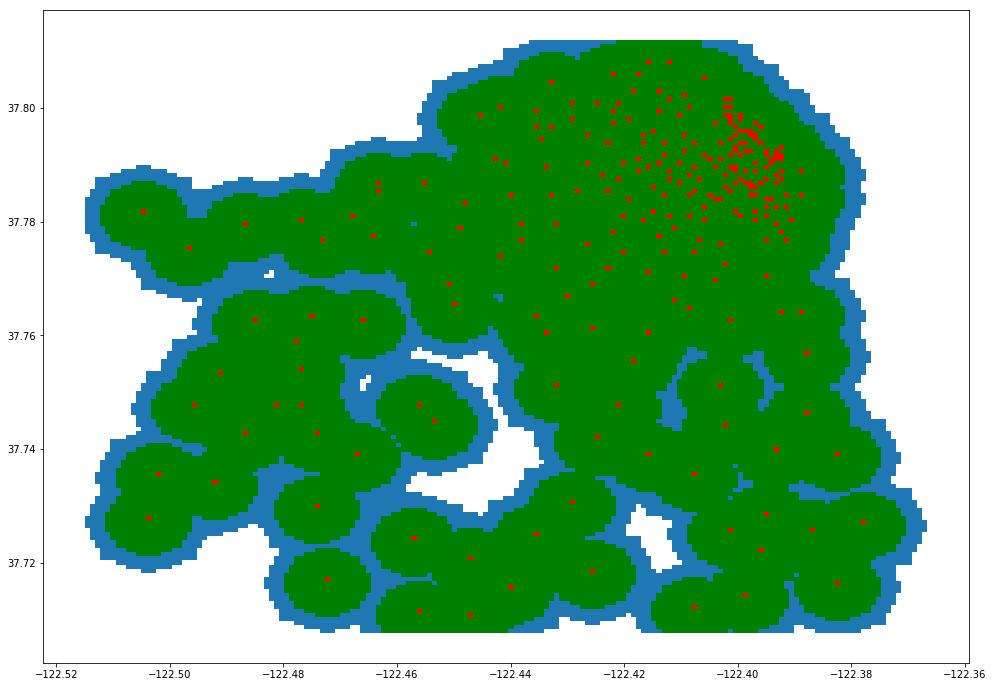

In [24]:
base = sg_df.loc[sg_df['speed'] == 100].plot(figsize=(30,12))
base_2 = sg_df.loc[sg_df['speed'] == 1000].plot(ax=base, color='g', figsize=(30,12))
t_df.plot(ax=base_2, color='r', figsize=(30,12))